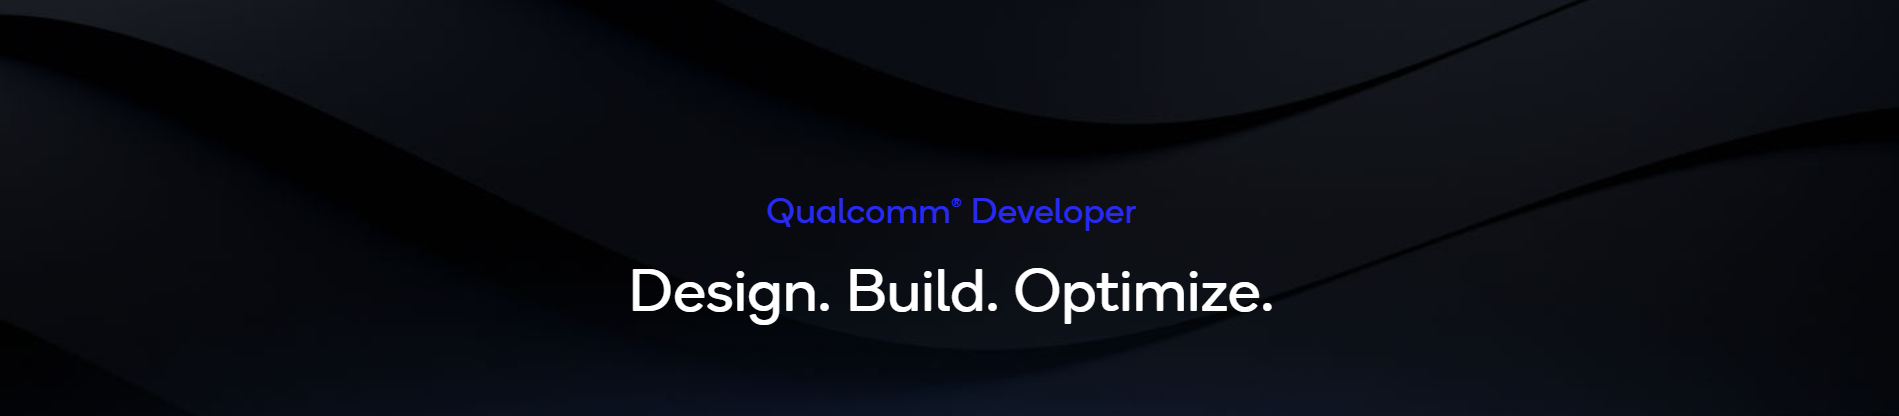

In [24]:
import onnxruntime as ort
import os
import torch

import cv2 as cv
import numpy as np

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from pathlib import Path

In [25]:
root_dir = Path.cwd().parent
root_dir

WindowsPath('C:/Users/DFS/Desktop/gitrepo/qnn_sample_apps')

In [30]:
# ONNX Session Setup
model_subdirectory = "hrnet_pose"
model_name = "hrnet_pose.onnx"
system = "aarch64-windows-msvc"
model_path = os.path.join(root_dir,"models",model_name)
session = ort.InferenceSession(model_path,
                                providers= ["QNNExecutionProvider"]
                              )
# Retrieve expected input from model
inputs = session.get_inputs()
input_0 = inputs[0] 

In [31]:
print(f"Expected Input Shape: {input_0.shape}")
print(f"Expected Input Type: {input_0.type}")
print(f"Expected Input Name: {input_0.name}")

Expected Input Shape: [1, 3, 256, 192]
Expected Input Type: tensor(float)
Expected Input Name: image


### Input Frame needs to be transformed to the below parameters based on get_inputs()
1. Shape: (1,3,256,192) => (B,C,H,W)
2. Datatype: Float 32
3. Name: Image

In [32]:
# PyTorch Frame Transform Setup
expected_shape = input_0.shape

transformer = v2.Compose([
    v2.Resize(size=(expected_shape[2],expected_shape[3]),interpolation=InterpolationMode.BICUBIC),
    v2.ToDtype(torch.float32, scale=False),  #v2.ToDtype(torch.float32, scale=False)
    v2.ToTensor()
])


In [33]:
cap = cv.VideoCapture(1)

if not cap.isOpened():
    print("Oh lordT")
    exit()

og_height, og_width = expected_shape[2], expected_shape[3]
output_height, output_width = 64, 48

scaler_height = og_height/output_height
scaler_width = og_width/output_width
    
while True:
    # time.sleep(1)
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break
    
    frame = Image.fromarray(frame) 
    frame = transformer(frame) #
    frame = frame.permute(1,2,0).numpy()

    ########################################################################
    ## INFERENCE
    ########################################################################
    inference_frame = np.expand_dims(np.transpose(frame, (2,0,1)), axis=0) 
    outputs = session.run(None, {input_0.name:inference_frame})
    output_tensor = torch.tensor(outputs).squeeze(0).squeeze(0)
    keypoints_coordinates = []
    
    for i in range(output_tensor.shape[0]):
        heatmap = output_tensor[i]
        max_val = torch.argmax(heatmap)
        img_height, img_width = torch.unravel_index(max_val, heatmap.shape) #coords = torch.unravel_index(max_val, heatmap.shape)
        coords = (int(img_height*scaler_height), int(img_width*scaler_width))
        keypoints_coordinates.append(coords)
    ########################################################################
    ########################################################################
    ########################################################################

    # MAP KEYPOINTS BACK TO ORIGINAL FRAME THEN DISPLAY THAT FRAME
    frame = (frame*255).astype(np.uint8)
    frame = frame.copy()
    for (y,x) in keypoints_coordinates:
        cv.circle(frame, (x,y), radius=3, color=(0,0,255), thickness=-1)
        
    frame = cv.resize(frame, (640,480), interpolation=cv.INTER_CUBIC)    
    cv.imshow('frame',frame)
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()